In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeRegressor

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np

In [3]:
import pandas as pd
import os

INPUT_DIR = ".\\data"

OUTPUT_DIR = ".\\data\\all"

all_dfs = []

for season in range(2003,2023):
    
    df = pd.read_csv(os.path.join(os.path.join(INPUT_DIR,str(season)),f"{season}_table.csv"))
    # df = df[["Team","Overall_Pla","Home_Pla","Away_Pla"]]
    # df.rename(columns={
    #     "Team": "team",
    #     "Overall_Pla": "overall",
    #     "Home_Pla": "home",
    #     "Away_Pla": "away"
    # }, inplace=True)
    df["Season"] = season
    df_next_season = pd.read_csv(os.path.join(os.path.join(INPUT_DIR,str(season+1)),f"{season+1}_table.csv"))[["Team","Overall_Pla"]]
    df_next_season.rename(columns={
        "Overall_Pla": "Next_Season_Overall_Pla"
    }, inplace=True)
    merged_df = df.merge(df_next_season, on='Team', how='left')
    all_dfs.append(merged_df)

final_df = pd.concat(all_dfs, ignore_index=True)

os.makedirs(OUTPUT_DIR, exist_ok=True)

final_df.to_csv(os.path.join(OUTPUT_DIR,"all_tables.csv"), index=False)

In [4]:
df_total = pd.read_csv("./data/all/all_tables.csv")
# df_total = pd.get_dummies(df_total, columns=["Team"])
df_total = df_total.drop(columns=["Team"])
df_total.rename(columns={
        "Next_Season_Overall_Pla": "Target"
    }, inplace=True)
df_total = df_total.fillna(0)
df_total["Target"] = df_total["Target"].astype(int)

In [5]:
# Embaralhamento dos dados para não ficar na ordem de data e não ter viés

df_total = df_total.sample(frac=1, random_state=42)

In [6]:
df_total.columns

Index(['Home_Vict', 'Home_Draw', 'Home_Loss', 'Away_Vict', 'Away_Draw',
       'Away_Loss', 'Overall_Pla', 'Home_Pla', 'Away_Pla', 'Season', 'Target'],
      dtype='object')

<Axes: >

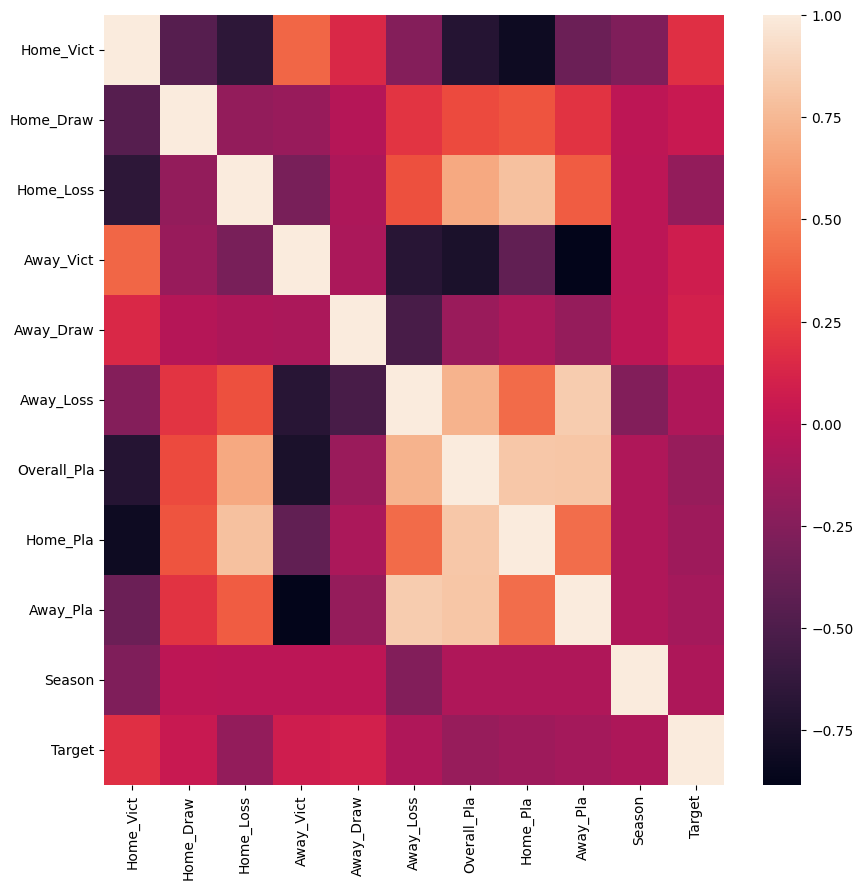

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_total.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [10]:
# Divisão do DataFrame em Treino e Teste

X_train, X_test, y_train, y_test = train_test_split(df_total.drop('Target', axis=1), df_total['Target'], test_size=0.2, random_state=42)

## Linear Regression

In [11]:
model_linear = LinearRegression()

# Parâmetros que queremos testar no modelo de regressão através do GridSearchCV
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, 1, 2, 5, 10],
    'positive': [True, False],

}

# Obtém o melhor modelo através do GridSearchCV
grid_search = GridSearchCV(model_linear, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)


# Vamos adotar o melhor regressor
model_linear = grid_search.best_estimator_

# Agora vamos medir o desempenho deste regressor com validação cruzada.
linear_scores = cross_val_score(model_linear, X_train, y_train, 
                                    scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

linear_rmse_scores = np.sqrt(-linear_scores)


print(f"Pontuações: {linear_rmse_scores}")

Pontuações: [7.16743481 5.76157172 7.05115843 6.61721462 5.94920635 6.40762183
 6.07868138 6.0741331  6.05453432 6.94907024]


## Random Forest Regression

In [12]:
# Criação do modelo de regressão
model_random_forest = RandomForestRegressor(random_state=42)

# Escolhemos os parâmetros que queremos testar no _random_foresto de regressão através do GridSearchCV
param_grid = {
    'n_estimators': [1, 10, 100, 500],
    'max_depth': [None, 3, 5, 10, 50],
    'min_samples_split': [0.001, 0.01, 0.1, 2],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Obtemos o melhor modelo através do GridSearchCV
grid_search = GridSearchCV(model_random_forest, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)

# Treinamos o modelo com os dados de treino
grid_search.fit(X_train, y_train)

# Vamos adotar o melhor regressor
model_random_forest = grid_search.best_estimator_

# Agora vamos medir o desempenho deste regressor com validação cruzada.
random_forest_scores = cross_val_score(model_random_forest, X_train, y_train, 
                                    scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

random_forest_rmse_scores = np.sqrt(-random_forest_scores)

print(f"Pontuações: {random_forest_rmse_scores}")

Pontuações: [6.51775185 5.327615   6.15754224 4.92013986 3.98686871 5.22274332
 5.18083132 4.68953981 5.54369588 5.69670846]


## Lasso

In [13]:
# Parâmetros que queremos testar no modelo de regressão através do GridSearchCV
param_grid = {
    'alpha':[0.001,0.01,0.05,0.1,0.5,1, 2, 3, 4, 5, 10],
    "fit_intercept": [True, False],
    "copy_X": [True,False],
    "warm_start": [True, False],
    "selection": ['cyclic', 'random']
}

# Cria modelo
model_lasso = Lasso()

# Obtém o melhor modelo através do GridSearchCV
grid_search = GridSearchCV(model_lasso, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)


# Vamos adotar o melhor regressor
model_lasso = grid_search.best_estimator_

# Agora vamos medir o desempenho deste regressor com validação cruzada.
lasso_scores = cross_val_score(model_lasso, X_train, y_train, 
                                    scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

lasso_rmse_scores = np.sqrt(-lasso_scores)

print(f"Pontuações: {lasso_rmse_scores}")

Pontuações: [7.14002388 5.73552213 7.13602303 6.57303282 5.91204243 6.37550654
 6.06141644 6.07533331 6.09091643 6.90764265]


c:\Users\jalfr\OneDrive\Desktop\illini\BRASA\Code\Illinois_Brasileirao_Analysis\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e+03, tolerance: 3.485e+00
  model = cd_fast.enet_coordinate_descent(


## Ridge


In [14]:
# Cria modelo
model_ridge = Ridge()

# Parâmetro que queremos testar no modelo Ridge através do GridSearchCV
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}


# Obtém o melhor modelo através do GridSearchCV
grid_search = GridSearchCV(model_ridge, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)


# Vamos adotar o melhor regressor
model_ridge = grid_search.best_estimator_

# Agora vamos medir o desempenho deste regressor com validação cruzada.
ridge_scores = cross_val_score(model_ridge, X_train, y_train, 
                                    scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

ridge_rmse_scores = np.sqrt(-ridge_scores)

print(f"Pontuações: {ridge_rmse_scores}")

Pontuações: [7.14482602 5.73121732 7.16266788 6.58248325 5.91765309 6.38203677
 6.08887532 6.09613518 6.10382708 6.90187841]


## Elastic Net

In [15]:
param_grid = {
    'alpha':[0.001,0.01,0.05,0.1,0.5,1],
    'l1_ratio':[0.1, 0.01, 0.5, 0.05, 0.001],
    "fit_intercept": [True, False],
    "copy_X": [True,False],
    "warm_start": [True, False],
    "selection": ['cyclic', 'random']
}

# Cria modelo
model_elastic_net = ElasticNet()

# Obtém o melhor modelo através do GridSearchCV
grid_search = GridSearchCV(model_elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)


# Vamos adotar o melhor regressor
model_elastic_net = grid_search.best_estimator_

# Agora vamos medir o desempenho deste regressor com validação cruzada.
elastic_net_scores = cross_val_score(model_elastic_net, X_train, y_train, 
                                    scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

elastic_net_rmse_scores = np.sqrt(-elastic_net_scores)

print(f"Pontuações: {elastic_net_rmse_scores}")

Pontuações: [7.14316171 5.7414729  7.1100877  6.58977829 5.9235869  6.37713322
 6.06783956 6.07614164 6.08877063 6.90900815]


c:\Users\jalfr\OneDrive\Desktop\illini\BRASA\Code\Illinois_Brasileirao_Analysis\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.345e+03, tolerance: 3.485e+00
  model = cd_fast.enet_coordinate_descent(


## Decision Tree Regressor

In [16]:
param_grid = {
    'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 20, 50]
}

# Cria modelo
model_tree = DecisionTreeRegressor()

# Obtém o melhor modelo através do GridSearchCV para o modelo ElasticNet
grid_search = GridSearchCV(model_tree, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)


# Vamos adotar o melhor regressor
model_tree = grid_search.best_estimator_

# Agora vamos medir o desempenho deste regressor com validação cruzada.
tree_scores = cross_val_score(model_tree, X_train, y_train, 
                                    scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

tree_rmse_scores = np.sqrt(-tree_scores)

feature_importances = model_tree.feature_importances_

print(f"Pontuações: {tree_rmse_scores}")

Pontuações: [6.66937387 6.03354709 6.38281708 4.94398254 4.1167633  5.23337902
 5.50604764 5.05066256 5.81759105 6.09447441]


## Model Comparison

In [17]:
def compare_scores(scores_1, scores_2):
    t_stat, p_value = ttest_ind(scores_1, scores_2, equal_var=False)
    print("Valor da estatística t: {:.2f}".format(t_stat))
    print("Valor-p: {}".format(p_value))
    return t_stat, p_value


def compare_models(name1, rmse_scores1, name2, rmse_scores2):
    t_stat, p_value = compare_scores(rmse_scores1, rmse_scores2)
    if p_value < 0.05:
        print(f'Erro médio de {name1} é significavelmente diferente de {name2}.')

In [18]:
models = {
    'Random Forest': random_forest_rmse_scores,
    'Linear Regression': linear_rmse_scores,
    'Lasso': lasso_rmse_scores,
    'Ridge': ridge_rmse_scores,
    'Elastic Net': elastic_net_rmse_scores,
    'Decision Tree': tree_rmse_scores
}

for model1, scores1 in models.items():
    for model2, scores2 in models.items():
        if model1 != model2:
            print("Comparando {} e {}:".format(model1, model2))
            compare_models(model1, scores1, model2, scores2)
            print()

Comparando Random Forest e Linear Regression:
Valor da estatística t: -3.90
Valor-p: 0.0012611675070391289
Erro médio de Random Forest é significavelmente diferente de Linear Regression.

Comparando Random Forest e Lasso:
Valor da estatística t: -3.84
Valor-p: 0.0014036396770305973
Erro médio de Random Forest é significavelmente diferente de Lasso.

Comparando Random Forest e Ridge:
Valor da estatística t: -3.88
Valor-p: 0.0012994985469823037
Erro médio de Random Forest é significavelmente diferente de Ridge.

Comparando Random Forest e Elastic Net:
Valor da estatística t: -3.86
Valor-p: 0.0013569283075155925
Erro médio de Random Forest é significavelmente diferente de Elastic Net.

Comparando Random Forest e Decision Tree:
Valor da estatística t: -0.78
Valor-p: 0.4446834369645182

Comparando Linear Regression e Random Forest:
Valor da estatística t: 3.90
Valor-p: 0.0012611675070391289
Erro médio de Linear Regression é significavelmente diferente de Random Forest.

Comparando Linear Re

## Testing

In [19]:
# Faz as previsões do modelo
y_pred = model_random_forest.predict(X_test)

# Calculamos a performance do modelo
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error (Placement):", np.sqrt(mse))

Mean Squared Error: 28.49649726691572
Root Mean Squared Error (Placement): 5.338211054924273
